# The problem
Say $n$ items are placed into one of $D$ containers independently and according to a uniform probability distribution (i.e., the probability that any item is placed into a specific container is $\frac{1}{D}$). What value of $n$ is needed so that the probability that at least $k$ containers hold at least one item is at least $p^{*}$?

The above is a generalization of the original question: how many people are needed before there's at least a 50% chance that their birthdays cover all 365 days of the year?

_Thought of while being unable to sleep at ~2 AM a few days before 6 July 2017. Solved while being unable to sleep at ~2 AM the morning of 4 Oct 2017. Writeup finished while being unable to sleep at ~2 AM the morning of 5 Oct 2017. How appropriate._

## The math

We have that

$$p = \frac{\text{the total number of good states}}{\text{the total number of possible states}} = \frac{G(n,k;d)}{T(n,k;d)}$$

It is important not to remove the degeneracy of configurations in this problem. In a sense, the degeneracy makes more probable configurations have more weight in determining the final probability. (As a toy example, if 990 mutually indistinguishable configurations satisfied a condition and 10 mutually distinct configurations did not satisfy that condition, we would say the probability of finding the system in a configuration that satisfies the condition to be $\frac{990}{990+10} = \frac{99}{100}$, not $\frac{1}{1+10} = \frac{1}{11}$.)


One can make a mapping from all possible configurations (including redundancies) with $d$ containers and $n$ items to the leaves of a tree with a branch factor of $D$ and a height of $n$ (denoting the root of the tree to have height 0). Then $T(n,k;D)$ is simply the total number of leaves, or $D^n$.

Instead of calculating $G$ directly, it would behoove us to calculate the number of configurations with *exactly* $k$ bins filled instead. Call this $g(n,k;D)$. <br>
We can easily recover $G$ from $g$ by noting that
$$ G(n,k;D) = \sum_{i=k}^{D} g(n,i;D) $$

So how do we calculate $g$? ~~We'll need to time the trajectories of falling objects and use Newton's Second Law.~~ <br>
Well, let's suppose we know $g(x, y; D)$ for all $x < n, y \in \{0, 1, \cdots, D\}$ and we want to know what interesting things can happen when we place the $n^{\text{th}}$ element.
- If a configuration with $n-1$ elements is already contained entirely within $k$ bins, we can place the $n^{\text{th}}$ element in any of the $k$ currently occupied bins. There are $g(n-1, k; D)$ such configurations.
- If a configuration with $n-1$ elements is contained within exactly $k-1$ bins, then if we place the $n^{\text{th}}$ element in any of the $D-(k-1) = D - k + 1$ currently vacant bins, then we will have just reached our desired target of $k$ occupied bins. There are $g(n-1, k-1; D)$ such configurations.
- We only have one element to place, so we can only either increase the total number of satisfied bins by one or by zero. So any configurations accounted for in $\{g(n-1, y; D)\; | \;y \notin \{k-1, k\}\} $ cannot contribute to $g(n, k; D)$.

Obviously we can't satisfy the requirement if $n < k$, so $g(n<k) = 0$. Also, if $n > 0$, at least one bin must contain an item, so $g(n \neq 0, k = 0) = 0$. Finally, when $n = k$, we can place the $n$ items in any $k$ of the $D$ containers to satisfy the requirement, so
$$ g(n = k; D) = D \times (D-1) \times \cdots \times (D - (k-1)) = \frac{D!}{(d-k)!} = P(D, k) $$

where $P$ is the permutation function.

Putting it all together, we have the following recurrence relation for g:

$$ g(n, k; D) = k*g(n-1,k;D) + (D-k+1) * g(n-1, k-1; D), \\
\quad g(n<k) = 0, \quad g(n \neq 0, k = 0) = 0, \quad g(n = k; D) = \frac{D!}{(d-k)!}$$

We can calculate the values for g via dynamic programming, then calculate $G$ from the rows of g, and finally calculate $p$ and see how it relates to $p^{*}$ to determine when we've found our answer. This method runs in $O(Dn)$ time.

<br>
Worth noting is that we've essentially calculated the multinomial distribution for a specific number of dividend factors $D$ in $O(Dn)$ time:
$$ MN(n;D) = \frac{n!}{\prod_{i=1}^{D} n_{i}!}; \quad 0 \leq n_{i} \leq n \; \forall \, i; \quad \sum_{i} n_{i} = n $$ 

Which is way better than having gone through and calculated them all individually. (Probably worth avoiding algorithms with $\omega(D^n)$ complexity for the time being.)

Alright, with that, I've paid my mathematical dues. Onward to the code-y stuff.

## The code

In [1]:
def permute(d,k):
    prod = 1
    for x in range(0, k):
        prod *= (d-x)
    return prod

In [2]:
start_marker = 'n_start'
end_marker = 'n_end'
bins_marker = 'D'
lean_cache_width = 2

In [3]:
# def memoize(f):
#     cache = {}
#     def memoized_func(*args, **kwargs):
#         if args not in cache:
#             cache[args] = f(*args)
#         return cache[args]
#     memoized_func.cache = cache
    
#     return memoized_func

# # @memoize
# # Because of the not-so-great nature of recursion in Python,
# # will implement the solution via filling a 2D array (in reality, a dictionary)
def calc_g(N, D, lean = True, old_answers = None):
    """
    For all values (n <= N, k <= D), calculate the number of configurations where x elements
    fall into exactly k of the D containers.
    Returns a dictionary of (n,k) -> # of configurations.
    
    An object passed into old_answers is checked to see if it is a dictionary
    whose value for the key bins_marker matches that of the parameter D.
    If so, will assume the answers in the dictionary are accurate and continue from where it left off
    by checking its start_marker and end_marker entries (which must also exist).
    
    If lean is True, the cache dictionary will only use O(1) memory.
    (Subsequent calls to this function for n <= N will not be able to use the cache dict.)
    """
    answers = {}
    n_start = 0
    try:
        assert old_answers[bins_marker] == D
        assert old_answers[start_marker] <= N
        if old_answers[end_marker] >= N:
            return old_answers
        answers = old_answers
    except:
        # old dict not useful; start from scratch
        answers = {bins_marker: D, start_marker: 0 - lean_cache_width+1, end_marker: 0}
    finally:
        # if we're here, we got to go past where the last valid answers dict reached
        try:
            n_start = answers[end_marker] + 1 # need to calculate values of n > answers[end_marker]
        except:
            pdb.set_trace()
        answers[end_marker] = N # will be true by end of function call
    
    for n in range(n_start, N+1):
        for k in range(0, D+1):
            if k == 0 or n < k:
                answers[(n,k)] = 0
            elif n == k:
                answers[(n,k)] = permute(D,k)
            else:
                answers[(n,k)] = (D-k+1)*answers[(n-1,k-1)] + k*answers[(n-1,k)]
            if lean:
                answers.pop((n-lean_cache_width, k-1), None)
        if lean:
            answers[start_marker] += 1
            answers.pop((n-lean_cache_width, D), None)
    
    
    
    return answers

In [4]:
def calc_p(n, k, D, answers):
    return (sum(answers[(n,x)] for x in range(k, D+1)) / (D**n))


def search_in_answers(p, k, D, answers):
    """
    Assuming there exists an n whose values are cached in the answers dict such that 
    calc_p(n-1, k, D, answers) < p and calc_p(n,k,D, answers) >= p,
    returns this value n.
    
    If this specific value n is not in answers, throws an AssertionError.
    """
    # binary search
    left = answers[start_marker]
    # ensure we'll find a valid answer
    assert calc_p(left, k, D, answers) < p
    right = answers[end_marker]
    
    diff = (right - left) // 2
    
    while (right - left) != 1:
        if calc_p(left + diff, k, D, answers) < p:
            left += diff
            diff = (right - left) // 2
        if calc_p(right - diff, k, D, answers) >= p:
            right -= diff
            diff = (right - left) // 2
    # will exit loop when diff = 1
    # at this point, right has the answer
    return right
    
    
# @time_function
def find_n(p, k, D, lean = True, old_answers = {}):
    """
    Find the the minimum number needed to have probability at least p that *at least* k (of D) bins have one item.
    Pass in an old_answers array to potentially save time (calc_g will perform the check).
    If lean is False, 
        returns (n, answers), the desired number and the cached answer dictionary.
    If lean is True,
        answers will only contain the values corresponding to n and (n-1).
        (This is best left True for large D and p approaching 1. 
        Otherwise, the function is liable to eat up all your RAM.
        You've been warned!)
    """
    if k > D:
        print("k = {0} is not allowed to be greater than D = {1}. Please try again.".format(k, D))
        return -1, {}
    
    answers = {}
    try:
        assert old_answers[bins_marker] == D
        answers = old_answers
        n_cur = answers[end_marker]
        if p < calc_p(n_cur,k,D,answers): # answer already in answers dict
            n_cur = search_in_answers(p, k, D, answers) # find it
            return n_cur, answers
    except:
        pass
    finally:
        n_cur = k # least possible value

    
    p_cur = 0
    while p_cur < p:
        answers = calc_g(n_cur, D, old_answers = answers)
        p_cur = calc_p(n_cur,k,D,answers)
        if lean:
            n_cur += 1 # only using finite space; need to be conservative
        else:
            n_cur *= 2
    # out of loop; our desired value must be in answers
    return search_in_answers(p, k, D, answers), answers
    

In [5]:
# for curiosity's sake
def time_function(f, show_dict = False):
    def func_results(*args, **kwargs):
        # quick 'n' dirty; not removing the time elapsed for timeit.time() function call
        start = timeit.time.time()
        results = f(*args, **kwargs)
        end = timeit.time.time()
        
        print("{0} took {1} seconds to run.".format(f.__name__, end - start))
#         print("It was given the parameters {0}".format((*args, kwargs)))
        return results
    return func_results

Alright, that should do it. Let's do a quick test that would be small enough to check by hand:

In [6]:
n, answers = find_n(p = 0.7, k = 2, D = 3, lean = True)
print('n = {0}'.format(n))

n = 3


And let's answer my original question (or at least a simplified form where people's birthdays are uniformly distributed -- see the end of this notebook for elaboration):

In [7]:
n, answers = find_n(p = 0.5, k = 365, D = 365, lean = True)
print('n = {0}'.format(n))

n = 2287


Neat.

For fun, let's sweep out a graph for the number of people needed to reach a threshold probability that their birthdays cover all 365 days of the year, ignoring February 29. (No offense! Though the existence of February 29 raises some interesting questions regarding non-uniform distributions -- again, see the end of this notebook.) So let's set k = D = 365 and see what kind of plot we get!

In [8]:
# not going to worry about possible floating-point shenanigans
def frange(a, b, step):
    while a < b:
        yield a
        a += step

In [9]:
def collect_pn(k, D):
    p_coords, n_coords = [], []
    answers = {}
    
    arg_dict = {'k': k, 'D': D, 'answers': answers, 'p_coords': p_coords, 'n_coords': n_coords}
    
    def sweep_p(a, b, step, kw_dict):
        for p in frange(a, b, step):
            n, answers = find_n(p, kw_dict['k'], kw_dict['D'], old_answers = kw_dict['answers'])
            kw_dict['answers'] = answers
            kw_dict['p_coords'].append(p), kw_dict['n_coords'].append(n)
    
    sweep_p(0.001, 0.0099, 0.001, arg_dict)
    sweep_p(0.01, 0.99, 0.01, arg_dict)
    sweep_p(0.99, 0.9999, 0.001, arg_dict)
    
    return arg_dict['p_coords'], arg_dict['n_coords']

D = 365
frac = 1
k = int(frac*D)

p_coords, n_coords = collect_pn(k,D)


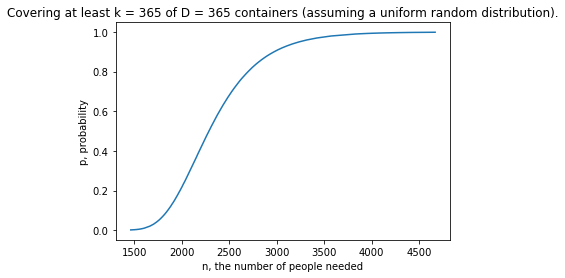

In [10]:
import matplotlib.pyplot as plt

plt.plot(n_coords, p_coords)
plt.title("Covering at least k = {0} of D = {1} containers (assuming a uniform random distribution).".format(k, D))
plt.xlabel('n, the number of people needed')
plt.ylabel('p, probability')
plt.show()

(I wonder what the ensemble of configurations looks like near $n \approx 1600$ for the probability to shoot up after that value.)

# Some closing thoughts

The existence of February 29 (occurring $\frac{1}{4}$ as often as any other calendar day) raises the question of how to generalize this to non-uniform distributions. (Also, practically speaking, even notwithstanding February 29, this model wouldn't apply to my birthday question in its current form -- the distribution of people's birthdays contains bumps nine months after holidays like New Year's Eve and Valentine's Day among other non-uniformities.) My immediate thought is that we'd have to count the number of configurations wherein a distinct set of containers (with different probabilities) hold the threshold number of elements (1, for our purposes so far), and weight each such configuration based on their frequency relative to the least likely container. But something tells me it might be slightly more complicated than that. <br>
Another question is how to generalize our solution, except that at least $m$ elements must be in the at least $k$ containers. Would we be able to simply expand our dynamic programming algorithm to go along the $m$ dimension as well, or is there something dubious behind that thought process?<br>

So many interesting things to explore!

\- DK